# Exercise - controlling a cart-pole system with a neural network

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
from torch import nn, tensor
import numpy as np
import torch
from skorch import NeuralNetBinaryClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

1. Familiarize with the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment of the _Gym_ library. Write a function that plays a given number of games using a model - provided as a parameter to the function, along with the number of games - for the choice of actions. If the model is not provided, choose random actions. The function should return a list of the total scores obtained in each game.

In [2]:
def play_games(num_games, model=None):
    scores = []
    env = gym.make('CartPole-v1')
    for _ in range(num_games):
        env.reset()
        score = 0.
        prev_obs = []
        for _ in range(500):
            if len(prev_obs)== 0 or model is None:
                action = env.action_space.sample()
            else:
                prev_obs = torch.tensor([prev_obs])
                action = model.predict(prev_obs).item()
                        
            new_observation, reward, terminated, truncated, info = env.step(action)
            prev_obs = new_observation
            score += reward
            if terminated or truncated:
                break
        scores.append(score)
    
    env.close()
    return scores

2. Write a function that generates the training data, _i.e._ a _list_ of pairs (observations, actions) for each sample (episode) for which the score is at least 60. The function should play a given number of games taking random actions in the range (0,1) using the environment `env`.

In [3]:
def generate_training_data(num_games):
    env = gym.make('CartPole-v1')
    training_data = []
    for _ in range(num_games):
        score = 0
        env.reset()
        game_memory = []
        previous_observation = []
        for _ in range(500):
            action = env.action_space.sample()
            observation, reward, terminated, truncated, info = env.step(action)
            
            if len(previous_observation) > 0:
                game_memory.append([previous_observation, action])
                
            previous_observation = observation
            score += reward
            if terminated or truncated:
                break
            
        if score >= 60:
            for data in game_memory:
                observations = data[0]
                actions = data[1]
                training_data.append([observations, actions])
    
    return training_data

3. Generate the training using the above function and reshape into two float32 PyTorch _tensors_:
- `X`: shape = (number of training states, 4)
- `y`: shape = (number of training states,)

_NOTE_: the number of games may be _large_... 

In [4]:
training_data = generate_training_data(100000)
X = tensor([i[0] for i in training_data], dtype=torch.float32).reshape(len(training_data),4)
y = tensor([i[1] for i in training_data], dtype=torch.float32)

/var/folders/6x/8nyd9hnd0n9dtx4st6g2d5zj_v2dvq/T/ipykernel_1411/677341328.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  X = tensor([i[0] for i in training_data], dtype=torch.float32).reshape(len(training_data),4)


4. Create a `skorch` [`NeuralNetBinaryClassifier`](https://skorch.readthedocs.io/en/stable/classifier.html?highlight=classifier) object based on the `NN` class below, which takes the 4 components of the observation as an input and returns the probability of pushing the cart to the right (action = 1). Start with one hidden layer with 128 ReLU units. Set the batch size equal to 64, the number of epochs equal to 200, the learning rate equal to 0.01, the criterion equal to the binary cross entropy loss, and the verbosity equal to 1.

In [5]:
class NN(nn.Module):
    def __init__(self, num_units=128):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, num_units),
            nn.ReLU(),
            nn.Linear(num_units,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(torch.float32)
        y = self.linear_relu_stack(x)
        return y

In [6]:
model = NeuralNetBinaryClassifier(module=NN, lr=0.01, batch_size=64, 
                                  verbose=1, max_epochs=200, 
                                  module__num_units=128,
                                  criterion=nn.BCELoss,
                                  iterator_train__shuffle=True)

5. Create a _pipeline_ and fit the model. Plot the history of the training and the validation losses.

In [7]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', model),
])

pipe.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6658       0.6086        0.6635  0.5671
      2        0.6611       0.6100        0.6607  0.5303
      3        0.6590       0.6094        0.6590  0.5178
      4        0.6578       0.6111        0.6578  0.5368
      5        0.6571       0.6100        0.6571  0.5338
      6        0.6566       0.6104        0.6568  0.5300
      7        0.6563       0.6112        0.6560  0.5364
      8        0.6560       0.6114        0.6556  0.5242
      9        0.6557       0.6111        0.6554  0.5211
     10        0.6555       0.6124        0.6554  0.5294
     11        0.6553       0.6111        0.6548  0.5211
     12        0.6552       0.6120        0.6547  0.5181
     13        0.6550       0.6108        0.6545  0.5241
     14        0.6548       0.6111        0.6553  0.5421
     15        0.6547       0.6103        0.6545  0.5353
     16        0.6546       0.6

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=NN(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
      (3): Sigmoid()
    )
  ),
))])

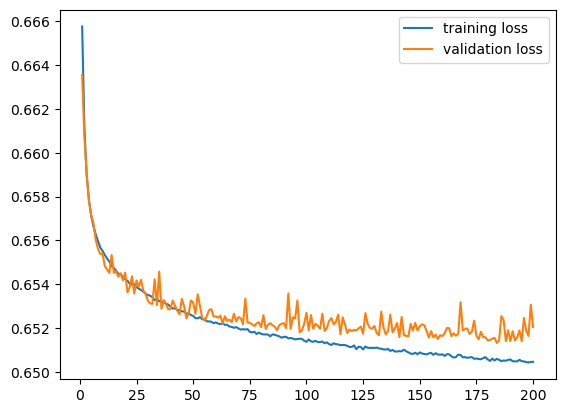

In [8]:
train_loss = pipe['model'].history[:, 'train_loss']
valid_loss = pipe['model'].history[:, 'valid_loss']
epochs = [i for i in range(1,len(train_loss)+1)]
plt.plot(epochs, train_loss, label='training loss')
plt.plot(epochs, valid_loss, label='validation loss')
plt.legend()
plt.show()

6. Play 1000 games where the actions are chosen according to the trained network. Record the total score per game and then compute the average score. Compare the average score with that of a random controller.

In [12]:
scores = play_games(1000, model=model)
print('Average Score', np.mean(scores))

Average Score 468.179


In [13]:
# random controller
scores = play_games(1000)
print('Average Score (random controller)', np.mean(scores))

Average Score (random controller) 22.141
